# Project information

**Title:** Mapping cancer cell line dependencies to patient populations


**Authors:** Sinead Dunphy, Alyson Freeman, Kristina Garber

36-alysonkf-kgarb-dunphysi

**Notebook location:** hhttps://colab.research.google.com/drive/1Dy1qnnoopjxErPVjeSIhodmZwc5yAKqA?usp=sharing

**Links to datasets:**

DepMap CRISPR dependencies data: https://ndownloader.figshare.com/files/29125323

DepMap RNAseq gene expression data: https://ndownloader.figshare.com/files/29124747

DepMap cell line metadata: https://ndownloader.figshare.com/files/29162481

TCGA RNAseq gene expression data: https://xenabrowser.net/datapages/?dataset=EB%2B%2BAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena&host=https%3A%2F%2Fpancanatlas.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

TCGA patient sample metadata: https://api.gdc.cancer.gov/data/1b5f413e-a8d1-4d10-92eb-7c4ae739ed81

TCGA study abbreviations and names: https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/tcga-study-abbreviations

Gene aliases: https://www.genenames.org/cgi-bin/download/custom?col=gd_app_sym&col=gd_prev_sym&col=gd_aliases&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit

# Library and data import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from IPython.display import display
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load in datasets

tcga_rnaseq = pd.read_csv('/content/drive/Shared drives/Milestone_I/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep='\t')
patient_data = pd.read_csv('/content/drive/Shared drives/Milestone_I/TCGA-CDR-SupplementalTableS1.csv')
gene_names = pd.read_csv('/content/drive/Shared drives/Milestone_I/gene_names.csv', dtype='string')
cancer_types = {'LAML':'Acute Myeloid Leukemia',
                'ACC':'Adrenocortical carcinoma',
                'BLCA':'Bladder Urothelial Carcinoma',
                'LGG':'Brain Lower Grade Glioma',
                'BRCA':'Breast invasive carcinoma',
                'CESC':'Cervical squamous cell carcinoma and endocervical adenocarcinoma',
                'CHOL':'Cholangiocarcinoma',
                'LCML':'Chronic Myelogenous Leukemia',
                'COAD':'Colon adenocarcinoma',
                'CNTL':'Controls',
                'ESCA':'Esophageal carcinoma',
                'FPPP':'FFPE Pilot Phase II',
                'GBM':'Glioblastoma multiforme',
                'HNSC':'Head and Neck squamous cell carcinoma',
                'KICH':'Kidney Chromophobe',
                'KIRC':'Kidney renal clear cell carcinoma',
                'KIRP':'Kidney renal papillary cell carcinoma',
                'LIHC':'Liver hepatocellular carcinoma',
                'LUAD':'Lung adenocarcinoma',
                'LUSC':'Lung squamous cell carcinoma',
                'DLBC':'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma',
                'MESO':'Mesothelioma',
                'MISC':'Miscellaneous',
                'OV':'Ovarian serous cystadenocarcinoma',
                'PAAD':'Pancreatic adenocarcinoma',
                'PCPG':'Pheochromocytoma and Paraganglioma',
                'PRAD':'Prostate adenocarcinoma',
                'READ':'Rectum adenocarcinoma',
                'SARC':'Sarcoma',
                'SKCM':'Skin Cutaneous Melanoma',
                'STAD':'Stomach adenocarcinoma',
                'TGCT':'Testicular Germ Cell Tumors',
                'THYM':'Thymoma',
                'THCA':'Thyroid carcinoma',
                'UCS':'Uterine Carcinosarcoma',
                'UCEC':'Uterine Corpus Endometrial Carcinoma',
                'UVM':'Uveal Melanoma'}

In [4]:
tcga_rnaseq

gene_id  ...  TCGA-CG-4477-01A-01R-1157-13
0        ?|100130426  ...                           NaN
1        ?|100133144  ...                     17.874417
2        ?|100134869  ...                     14.919338
3            ?|10357  ...                    703.713324
4            ?|10431  ...                   1736.988111
...              ...  ...                           ...
20526  ZYG11A|440590  ...                    217.431795
20527   ZYG11B|79699  ...                    859.078048
20528       ZYX|7791  ...                   2497.814797
20529    ZZEF1|23140  ...                   1247.130940
20530     ZZZ3|26009  ...                    916.155785

[20531 rows x 11070 columns]

In [5]:
patient_data

Unnamed: 0 bcr_patient_barcode type  ...  PFI PFI.time Redaction
0               1        TCGA-OR-A5J1  ACC  ...  1.0    754.0       NaN
1               2        TCGA-OR-A5J2  ACC  ...  1.0    289.0       NaN
2               3        TCGA-OR-A5J3  ACC  ...  1.0     53.0       NaN
3               4        TCGA-OR-A5J4  ACC  ...  1.0    126.0       NaN
4               5        TCGA-OR-A5J5  ACC  ...  1.0     50.0       NaN
...           ...                 ...  ...  ...  ...      ...       ...
11155       11156        TCGA-YZ-A980  UVM  ...  1.0   1556.0       NaN
11156       11157        TCGA-YZ-A982  UVM  ...  0.0    495.0       NaN
11157       11158        TCGA-YZ-A983  UVM  ...  0.0    798.0       NaN
11158       11159        TCGA-YZ-A984  UVM  ...  1.0    154.0       NaN
11159       11160        TCGA-YZ-A985  UVM  ...  0.0   1184.0       NaN

[11160 rows x 34 columns]

In [6]:
gene_names

Approved symbol  ... Unnamed: 3
0                A1BG  ...       <NA>
1            A1BG-AS1  ...       <NA>
2                A1CF  ...       <NA>
3               A1S9T  ...       <NA>
4                 A2M  ...       <NA>
...               ...  ...        ...
47943          ZYG11B  ...       <NA>
47944             ZYX  ...       <NA>
47945           ZYXP1  ...       <NA>
47946           ZZEF1  ...       <NA>
47947            ZZZ3  ...       <NA>

[47948 rows x 4 columns]

In [7]:
cancer_types

{'ACC': 'Adrenocortical carcinoma',
 'BLCA': 'Bladder Urothelial Carcinoma',
 'BRCA': 'Breast invasive carcinoma',
 'CESC': 'Cervical squamous cell carcinoma and endocervical adenocarcinoma',
 'CHOL': 'Cholangiocarcinoma',
 'CNTL': 'Controls',
 'COAD': 'Colon adenocarcinoma',
 'DLBC': 'Lymphoid Neoplasm Diffuse Large B-cell Lymphoma',
 'ESCA': 'Esophageal carcinoma',
 'FPPP': 'FFPE Pilot Phase II',
 'GBM': 'Glioblastoma multiforme',
 'HNSC': 'Head and Neck squamous cell carcinoma',
 'KICH': 'Kidney Chromophobe',
 'KIRC': 'Kidney renal clear cell carcinoma',
 'KIRP': 'Kidney renal papillary cell carcinoma',
 'LAML': 'Acute Myeloid Leukemia',
 'LCML': 'Chronic Myelogenous Leukemia',
 'LGG': 'Brain Lower Grade Glioma',
 'LIHC': 'Liver hepatocellular carcinoma',
 'LUAD': 'Lung adenocarcinoma',
 'LUSC': 'Lung squamous cell carcinoma',
 'MESO': 'Mesothelioma',
 'MISC': 'Miscellaneous',
 'OV': 'Ovarian serous cystadenocarcinoma',
 'PAAD': 'Pancreatic adenocarcinoma',
 'PCPG': 'Pheochromocytom

In [8]:
# change cancer_types to a dataframe

cancer_types = pd.DataFrame.from_dict(cancer_types, orient='index')
cancer_types.reset_index(inplace=True)
cancer_types.rename(columns={'index':'Study Abbreviation',0:'Study Name'}, inplace=True)
cancer_types

Study Abbreviation                                         Study Name
0                LAML                             Acute Myeloid Leukemia
1                 ACC                           Adrenocortical carcinoma
2                BLCA                       Bladder Urothelial Carcinoma
3                 LGG                           Brain Lower Grade Glioma
4                BRCA                          Breast invasive carcinoma
5                CESC  Cervical squamous cell carcinoma and endocervi...
6                CHOL                                 Cholangiocarcinoma
7                LCML                       Chronic Myelogenous Leukemia
8                COAD                               Colon adenocarcinoma
9                CNTL                                           Controls
10               ESCA                               Esophageal carcinoma
11               FPPP                                FFPE Pilot Phase II
12                GBM                            Glioblastoma multiforme
13               HNSC              Head and Neck squamous cell carcinoma
14               KICH                                 Kidney Chromophobe
15               KIRC                  Kidney renal clear cell carcinoma
16               KIRP              Kidney renal papillary cell carcinoma
17               LIHC                     Liver hepatocellular carcinoma
18               LUAD                                Lung adenocarcinoma
19               LUSC                       Lung squamous cell carcinoma
20               DLBC    Lymphoid Neoplasm Diffuse Large B-cell Lymphoma
21               MESO                                       Mesothelioma
22               MISC                                      Miscellaneous
23                 OV                  Ovarian serous cystadenocarcinoma
24               PAAD                          Pancreatic adenocarcinoma
25               PCPG                 Pheochromocytoma and Paraganglioma
26               PRAD                            Prostate adenocarcinoma
27               READ                              Rectum adenocarcinoma
28               SARC                                            Sarcoma
29               SKCM                            Skin Cutaneous Melanoma
30               STAD                             Stomach adenocarcinoma
31               TGCT                        Testicular Germ Cell Tumors
32               THYM                                            Thymoma
33               THCA                                  Thyroid carcinoma
34                UCS                             Uterine Carcinosarcoma
35               UCEC               Uterine Corpus Endometrial Carcinoma
36                UVM                                     Uveal Melanoma

In [9]:
# merge patient data with cancer types to get the full names of each cancer instead of just the 3 letter abbreviation

patient_data = pd.merge(patient_data, cancer_types, left_on='type', right_on='Study Abbreviation', how='left')
patient_data

Unnamed: 0  ...                Study Name
0               1  ...  Adrenocortical carcinoma
1               2  ...  Adrenocortical carcinoma
2               3  ...  Adrenocortical carcinoma
3               4  ...  Adrenocortical carcinoma
4               5  ...  Adrenocortical carcinoma
...           ...  ...                       ...
11155       11156  ...            Uveal Melanoma
11156       11157  ...            Uveal Melanoma
11157       11158  ...            Uveal Melanoma
11158       11159  ...            Uveal Melanoma
11159       11160  ...            Uveal Melanoma

[11160 rows x 36 columns]

In [10]:
# clean up the gene names and sample names

tcga_rnaseq.columns = tcga_rnaseq.columns.str.replace('-...-...-....-..$','',regex=True)
tcga_rnaseq['gene_id'] = tcga_rnaseq['gene_id'].str.replace('\|(.*)$', '', regex=True)
tcga_rnaseq = tcga_rnaseq[tcga_rnaseq['gene_id']!="?"]
tcga_rnaseq

gene_id  TCGA-OR-A5J1  ...  TCGA-CG-4476  TCGA-CG-4477
29       A1BG       16.3305  ...     24.972112     24.412300
30       A1CF        0.0000  ...           NaN           NaN
31      A2BP1       17.2911  ...           NaN           NaN
32      A2LD1      182.3920  ...    169.264644    132.496787
33        A2M    10373.7000  ...  34248.674797  14783.897918
...       ...           ...  ...           ...           ...
20526  ZYG11A        0.4803  ...      0.301440    217.431795
20527  ZYG11B      648.4150  ...    845.677334    859.078048
20528     ZYX     1841.0200  ...   3302.569055   2497.814797
20529   ZZEF1     1157.5400  ...   1915.477072   1247.130940
20530    ZZZ3      596.0620  ...   1027.285482    916.155785

[20502 rows x 11070 columns]

In [11]:
# make a dataframe of the approved gene symbols and all possible aliases

gene_names.drop(['Unnamed: 3'], axis=1, inplace=True)
gene_names = gene_names.replace('\}$','',regex=True)
gene_names.fillna('', inplace=True)
gene_names['All alias'] = gene_names['Approved symbol']+', '+gene_names['Previous symbols']+', '+gene_names['Alias symbols']
gene_names['All alias'] = gene_names['All alias'].str.split()
gene_names = gene_names.explode('All alias')
gene_names['All alias'] = gene_names['All alias'].str.strip(",")
gene_names['All alias'].replace('', np.nan, inplace=True)
gene_names.dropna(subset=['All alias'], inplace=True)
gene_names

Approved symbol  ...     All alias
0                A1BG  ...          A1BG
1            A1BG-AS1  ...      A1BG-AS1
1            A1BG-AS1  ...    NCRNA00181
1            A1BG-AS1  ...        A1BGAS
1            A1BG-AS1  ...       A1BG-AS
...               ...  ...           ...
47946           ZZEF1  ...          ZZZ4
47946           ZZEF1  ...      FLJ10821
47947            ZZZ3  ...          ZZZ3
47947            ZZZ3  ...  DKFZP564I052
47947            ZZZ3  ...         ATAC1

[107457 rows x 4 columns]

In [12]:
# change the gene names to the approved symbols to better match the depmap dataset

tcga_rnaseq = tcga_rnaseq.merge(gene_names, left_on='gene_id', right_on='All alias', how='left')
tcga_rnaseq.index=tcga_rnaseq['Approved symbol']
tcga_rnaseq.drop(['Approved symbol', 'Previous symbols', 'Alias symbols', 'All alias', 'gene_id'], axis=1, inplace=True)
tcga_rnaseq

TCGA-OR-A5J1  TCGA-OR-A5J2  ...  TCGA-CG-4476  TCGA-CG-4477
Approved symbol                              ...                            
A1BG                  16.3305        9.5987  ...     24.972112     24.412300
A1CF                   0.0000        0.0000  ...           NaN           NaN
RBFOX1                17.2911        5.6368  ...           NaN           NaN
GGACT                182.3920      239.1580  ...    169.264644    132.496787
A2M                10373.7000     9844.9100  ...  34248.674797  14783.897918
...                       ...           ...  ...           ...           ...
ZYG11A                 0.4803       31.4052  ...      0.301440    217.431795
ZYG11B               648.4150     1166.0200  ...    845.677334    859.078048
ZYX                 1841.0200     3059.9900  ...   3302.569055   2497.814797
ZZEF1               1157.5400     1895.9900  ...   1915.477072   1247.130940
ZZZ3                 596.0620      801.6370  ...   1027.285482    916.155785

[21201 rows x 11069 columns]

# PCA clustering for all indications

In [13]:
# calculate the variance of each gene across all samples

tcga_rnaseq.dropna(inplace=True)
tcga_rnaseq['variance'] = tcga_rnaseq.var(axis=1)
tcga_rnaseq

TCGA-OR-A5J1  TCGA-OR-A5J2  ...  TCGA-CG-4477      variance
Approved symbol                              ...                            
A1BG                  16.3305        9.5987  ...     24.412300  1.938552e+08
GGACT                182.3920      239.1580  ...    132.496787  3.454823e+04
A2M                10373.7000     9844.9100  ...  14783.897918  1.098792e+09
A2ML1                 54.7550        0.0000  ...   2214.996943  2.263764e+07
A4GALT               190.6820      198.8990  ...    249.948511  7.208512e+05
...                       ...           ...  ...           ...           ...
ZYG11A                 0.4803       31.4052  ...    217.431795  3.000949e+04
ZYG11B               648.4150     1166.0200  ...    859.078048  2.306140e+05
ZYX                 1841.0200     3059.9900  ...   2497.814797  9.910382e+06
ZZEF1               1157.5400     1895.9900  ...   1247.130940  4.149483e+05
ZZZ3                 596.0620      801.6370  ...    916.155785  1.098451e+05

[16884 rows x 11070 columns]

In [14]:
# keep the 5000 genes with the most variance

tcga_rnaseq.sort_values('variance', ascending=False, inplace=True)
tcga_variance = tcga_rnaseq[:5000].copy()
tcga_variance = tcga_variance.drop('variance', axis=1).T
tcga_variance

Approved symbol         ALB        FBF1  ...       RNF181         GGT5
TCGA-OR-A5J1       1.440900    1.440900  ...  2080.690000   499.520000
TCGA-OR-A5J2       5.234200    5.234200  ...   811.703000  1108.040000
TCGA-OR-A5J3       5.332500    5.332500  ...  1293.440000   401.126000
TCGA-OR-A5J5     312.936000  312.936000  ...  1405.110000   264.136000
TCGA-OR-A5J6       1.117700    1.117700  ...  2313.110000   126.302000
...                     ...         ...  ...          ...          ...
TCGA-CG-4472       0.383366    0.383366  ...   737.315255   677.618213
TCGA-CG-4474     104.665551  104.665551  ...   682.208636   932.411594
TCGA-CG-4475       2.247741    2.247741  ...  2147.830494   838.805807
TCGA-CG-4476     110.824956  110.824956  ...   953.809068  1013.770868
TCGA-CG-4477      34.871625   34.871625  ...   816.581880   389.159492

[11069 rows x 5000 columns]

In [15]:
# merge with patient data for study names (cancer types) and histology

tcga_variance = pd.merge(tcga_variance, patient_data[['bcr_patient_barcode','histological_type', 'Study Name']], left_index=True, right_on='bcr_patient_barcode', how='left')
tcga_variance.set_index('bcr_patient_barcode', inplace=True)
tcga_variance

ALB  ...                Study Name
bcr_patient_barcode              ...                          
TCGA-OR-A5J1           1.440900  ...  Adrenocortical carcinoma
TCGA-OR-A5J2           5.234200  ...  Adrenocortical carcinoma
TCGA-OR-A5J3           5.332500  ...  Adrenocortical carcinoma
TCGA-OR-A5J5         312.936000  ...  Adrenocortical carcinoma
TCGA-OR-A5J6           1.117700  ...  Adrenocortical carcinoma
...                         ...  ...                       ...
TCGA-CG-4472           0.383366  ...    Stomach adenocarcinoma
TCGA-CG-4474         104.665551  ...    Stomach adenocarcinoma
TCGA-CG-4475           2.247741  ...    Stomach adenocarcinoma
TCGA-CG-4476         110.824956  ...    Stomach adenocarcinoma
TCGA-CG-4477          34.871625  ...    Stomach adenocarcinoma

[11069 rows x 5002 columns]

In [16]:
tcga_variance.dropna(inplace=True)
tcga_variance.sort_values(by='Study Name', inplace=True)
tcga_variance

ALB  ...                Study Name
bcr_patient_barcode           ...                          
TCGA-OR-A5J1          1.4409  ...  Adrenocortical carcinoma
TCGA-OR-A5LD         50.2035  ...  Adrenocortical carcinoma
TCGA-OR-A5LC          1.3569  ...  Adrenocortical carcinoma
TCGA-OR-A5LB         13.9876  ...  Adrenocortical carcinoma
TCGA-OR-A5LA         17.7462  ...  Adrenocortical carcinoma
...                      ...  ...                       ...
TCGA-VD-AA8P          1.7123  ...            Uveal Melanoma
TCGA-VD-AA8Q          1.4706  ...            Uveal Melanoma
TCGA-VD-AA8R          0.8651  ...            Uveal Melanoma
TCGA-VD-A8KA          0.4625  ...            Uveal Melanoma
TCGA-WC-A882          0.0000  ...            Uveal Melanoma

[10377 rows x 5002 columns]

In [17]:
# find how many cancers are in each type

for cancer in tcga_variance['Study Name'].unique():
  df = tcga_variance[tcga_variance['Study Name']==cancer]
  print(cancer, len(df))
print('total', len(tcga_variance))

Adrenocortical carcinoma 79
Bladder Urothelial Carcinoma 427
Brain Lower Grade Glioma 533
Breast invasive carcinoma 1215
Cervical squamous cell carcinoma and endocervical adenocarcinoma 309
Cholangiocarcinoma 45
Colon adenocarcinoma 492
Esophageal carcinoma 196
Glioblastoma multiforme 168
Head and Neck squamous cell carcinoma 566
Kidney Chromophobe 91
Kidney renal clear cell carcinoma 606
Kidney renal papillary cell carcinoma 323
Liver hepatocellular carcinoma 424
Lung adenocarcinoma 576
Lung squamous cell carcinoma 553
Lymphoid Neoplasm Diffuse Large B-cell Lymphoma 48
Mesothelioma 87
Ovarian serous cystadenocarcinoma 309
Pancreatic adenocarcinoma 183
Pheochromocytoma and Paraganglioma 187
Prostate adenocarcinoma 550
Rectum adenocarcinoma 170
Sarcoma 265
Stomach adenocarcinoma 450
Testicular Germ Cell Tumors 139
Thymoma 122
Thyroid carcinoma 572
Uterine Carcinosarcoma 57
Uterine Corpus Endometrial Carcinoma 555
Uveal Melanoma 80
total 10377


In [18]:
# pca of 5000 samples

scaler = StandardScaler()
scaler.fit(tcga_variance.iloc[:5000, :-2])
x_scaled = scaler.transform(tcga_variance.iloc[:5000, :-2])

pca_5 = PCA(n_components=5)
pca_5.fit(x_scaled)
x_pca_5 = pca_5.transform(x_scaled)

print('Variance explained by 5 principal components: ', sum(pca_5.explained_variance_ratio_*100))



Variance explained by 5 principal components:  30.1782475050889


In [19]:
# visualization of first 5 pca components colored by cancer type

pca = pd.DataFrame()
pca['PCA1'] = x_pca_5[:,0]
pca['PCA2'] = x_pca_5[:,1]
pca['PCA3'] = x_pca_5[:,2]
pca['PCA4'] = x_pca_5[:,3]
pca['PCA5'] = x_pca_5[:,4]
pca['cancer'] = tcga_variance.reset_index().iloc[:5000,-1]
pca['histology'] = tcga_variance.reset_index().iloc[:5000,-2]

def my_theme():
    return {
        'config': {
            'range': {'category': {'scheme': 'tableau20'}}
      }
  }

alt.themes.register('my_theme', my_theme)
alt.themes.enable('my_theme')

chart = alt.Chart(pca).mark_circle().encode(
    alt.X(alt.repeat('column'), type='quantitative'),
    alt.Y(alt.repeat('row'), type='quantitative'),
    color = alt.Color('cancer'),
    tooltip = ['cancer', 'histology']
).repeat(
    row=['PCA1','PCA2','PCA3','PCA4','PCA5'],
    column=['PCA1','PCA2','PCA3','PCA4','PCA5']
)

chart

alt.RepeatChart(...)

# PCA clustering per lineage

In [20]:
tcga_rnaseq

TCGA-OR-A5J1  TCGA-OR-A5J2  ...  TCGA-CG-4477      variance
Approved symbol                              ...                            
ALB                    1.4409        5.2342  ...     34.871625  2.921344e+11
FBF1                   1.4409        5.2342  ...     34.871625  2.921344e+11
TG                    93.1796        7.2473  ...      5.878704  5.576683e+10
DLC1                  24.9760        0.4026  ...      6.511014  3.307098e+10
HP                    24.9760        0.4026  ...      6.511014  3.307098e+10
...                       ...           ...  ...           ...           ...
H4C12                  0.0000        0.0000  ...     -0.395080  1.439625e+00
SCARNA9L               0.0000        0.4026  ...     -0.117928  1.002322e+00
SEPTIN7P9              0.0000        2.0132  ...      0.468216  9.832929e-01
NaN                    0.4803        0.4026  ...      0.406786  5.591525e-01
SNORA62                0.0000        0.0000  ...     -0.123151  3.112648e-01

[16884 rows x 11070 columns]

In [21]:
# switch columns and rows

tcga_rnaseq = tcga_rnaseq.T

In [22]:
# merge with patient data for cancer type and histology

tcga_rnaseq = pd.merge(tcga_rnaseq, patient_data[['bcr_patient_barcode','histological_type', 'Study Name']], left_index=True, right_on='bcr_patient_barcode', how='left')
tcga_rnaseq.set_index('bcr_patient_barcode', inplace=True)
tcga_rnaseq

ALB  ...                Study Name
bcr_patient_barcode                ...                          
TCGA-OR-A5J1         1.440900e+00  ...  Adrenocortical carcinoma
TCGA-OR-A5J2         5.234200e+00  ...  Adrenocortical carcinoma
TCGA-OR-A5J3         5.332500e+00  ...  Adrenocortical carcinoma
TCGA-OR-A5J5         3.129360e+02  ...  Adrenocortical carcinoma
TCGA-OR-A5J6         1.117700e+00  ...  Adrenocortical carcinoma
...                           ...  ...                       ...
TCGA-CG-4474         1.046656e+02  ...    Stomach adenocarcinoma
TCGA-CG-4475         2.247741e+00  ...    Stomach adenocarcinoma
TCGA-CG-4476         1.108250e+02  ...    Stomach adenocarcinoma
TCGA-CG-4477         3.487163e+01  ...    Stomach adenocarcinoma
variance             2.921344e+11  ...                       NaN

[11070 rows x 16886 columns]

In [23]:
# drop samples missing histology and cancer type (Study Name)

tcga_rnaseq = tcga_rnaseq[tcga_rnaseq['histological_type']!='[Not Available]']
tcga_rnaseq = tcga_rnaseq[tcga_rnaseq['histological_type'].notna()]
tcga_rnaseq = tcga_rnaseq[tcga_rnaseq['Study Name'].notna()]
tcga_rnaseq

ALB  ...                Study Name
bcr_patient_barcode              ...                          
TCGA-OR-A5J1           1.440900  ...  Adrenocortical carcinoma
TCGA-OR-A5J2           5.234200  ...  Adrenocortical carcinoma
TCGA-OR-A5J3           5.332500  ...  Adrenocortical carcinoma
TCGA-OR-A5J5         312.936000  ...  Adrenocortical carcinoma
TCGA-OR-A5J6           1.117700  ...  Adrenocortical carcinoma
...                         ...  ...                       ...
TCGA-CG-4466           3.859966  ...    Stomach adenocarcinoma
TCGA-CG-4469           0.383366  ...    Stomach adenocarcinoma
TCGA-CG-4474         104.665551  ...    Stomach adenocarcinoma
TCGA-CG-4476         110.824956  ...    Stomach adenocarcinoma
TCGA-CG-4477          34.871625  ...    Stomach adenocarcinoma

[10363 rows x 16886 columns]

In [24]:
# simplify histology names for eosophageal

tcga_rnaseq['histological_type'] = tcga_rnaseq['histological_type'].str.replace('Esophagus Squamous Cell Carcinoma', 'Squamous')
tcga_rnaseq['histological_type'] = tcga_rnaseq['histological_type'].str.replace('Esophagus Adenocarcinoma, NOS', 'Adeno')
tcga_rnaseq

ALB  ...                Study Name
bcr_patient_barcode              ...                          
TCGA-OR-A5J1           1.440900  ...  Adrenocortical carcinoma
TCGA-OR-A5J2           5.234200  ...  Adrenocortical carcinoma
TCGA-OR-A5J3           5.332500  ...  Adrenocortical carcinoma
TCGA-OR-A5J5         312.936000  ...  Adrenocortical carcinoma
TCGA-OR-A5J6           1.117700  ...  Adrenocortical carcinoma
...                         ...  ...                       ...
TCGA-CG-4466           3.859966  ...    Stomach adenocarcinoma
TCGA-CG-4469           0.383366  ...    Stomach adenocarcinoma
TCGA-CG-4474         104.665551  ...    Stomach adenocarcinoma
TCGA-CG-4476         110.824956  ...    Stomach adenocarcinoma
TCGA-CG-4477          34.871625  ...    Stomach adenocarcinoma

[10363 rows x 16886 columns]

In [25]:
# pca for each cancer type (Study Name) using the top 5000 variant genes in that cancer

for cancer in tcga_rnaseq['Study Name'].unique():
    print('Study Name: ', cancer)

    # new df for each cancer type
    df = tcga_rnaseq[tcga_rnaseq['Study Name']==cancer]
    df = df.T
    df['variance'] = df.var(axis=1)
    df.sort_values(by='variance', ascending=False, inplace=True)
    df = df[:5000].copy()
    df = df.drop('variance', axis=1).T

    # merge with patient data for plotting
    df = pd.merge(df, patient_data[['bcr_patient_barcode','histological_type','Study Name']], left_index=True, right_on='bcr_patient_barcode', how='left')
    df['histological_type'] = df['histological_type'].str.replace('Esophagus Squamous Cell Carcinoma', 'Squamous')
    df['histological_type'] = df['histological_type'].str.replace('Esophagus Adenocarcinoma, NOS', 'Adeno')
    df.set_index('bcr_patient_barcode', inplace=True)
    df.dropna(inplace=True)
    
    scaler = StandardScaler()
    scaler.fit(df.iloc[:, :-2])
    x_scaled = scaler.transform(df.iloc[:, :-2])

    # 3 pca components
    pca_3 = PCA(n_components=3)
    pca_3.fit(x_scaled)
    x_pca_3 = pca_3.transform(x_scaled)

    print('Variance explained by 3 principal components: ', sum(pca_3.explained_variance_ratio_*100))    

    pca = pd.DataFrame()
    pca['PCA1'] = x_pca_3[:,0]
    pca['PCA2'] = x_pca_3[:,1]
    pca['PCA3'] = x_pca_3[:,2]
    pca['cancer'] = df.reset_index().iloc[:,-1]
    pca['histology'] = df.reset_index().iloc[:,-2]
    pca['sample'] = df.index

    def my_theme():
        return {
            'config': {
                'range': {'category': {'scheme': 'tableau20'}}
        }
    }

    alt.themes.register('my_theme', my_theme)
    alt.themes.enable('my_theme')
    
    chart = alt.Chart(pca).mark_circle().encode(
        alt.X(alt.repeat('column'), type='quantitative'),
        alt.Y(alt.repeat('row'), type='quantitative'),
        color = 'histology',
        tooltip = ['cancer', 'histology']
    ).repeat(
        row=['PCA1', 'PCA2', 'PCA3'],
        column=['PCA1','PCA2','PCA3'],
        title=cancer
    )
    
    display(chart)
    

Study Name:  Adrenocortical carcinoma
Variance explained by 3 principal components:  24.344077768253896


alt.RepeatChart(...)

Study Name:  Bladder Urothelial Carcinoma
Variance explained by 3 principal components:  21.71799990782676


alt.RepeatChart(...)

Study Name:  Lymphoid Neoplasm Diffuse Large B-cell Lymphoma
Variance explained by 3 principal components:  34.37877783365684


alt.RepeatChart(...)

Study Name:  Uterine Corpus Endometrial Carcinoma
Variance explained by 3 principal components:  21.199899535320117


alt.RepeatChart(...)

Study Name:  Head and Neck squamous cell carcinoma
Variance explained by 3 principal components:  23.62497246032844


alt.RepeatChart(...)

Study Name:  Prostate adenocarcinoma
Variance explained by 3 principal components:  30.195161404971895


alt.RepeatChart(...)

Study Name:  Kidney renal papillary cell carcinoma
Variance explained by 3 principal components:  27.328242253916237


alt.RepeatChart(...)

Study Name:  Pancreatic adenocarcinoma
Variance explained by 3 principal components:  30.28854207426979


alt.RepeatChart(...)

Study Name:  Sarcoma
Variance explained by 3 principal components:  21.35624726001437


alt.RepeatChart(...)

Study Name:  Cervical squamous cell carcinoma and endocervical adenocarcinoma
Variance explained by 3 principal components:  20.56159713000983


alt.RepeatChart(...)

Study Name:  Colon adenocarcinoma
Variance explained by 3 principal components:  28.148570641090537


alt.RepeatChart(...)

Study Name:  Lung squamous cell carcinoma
Variance explained by 3 principal components:  23.99377011111158


alt.RepeatChart(...)

Study Name:  Rectum adenocarcinoma
Variance explained by 3 principal components:  29.43423248481591


alt.RepeatChart(...)

Study Name:  Kidney renal clear cell carcinoma
Variance explained by 3 principal components:  28.038414389181884


alt.RepeatChart(...)

Study Name:  Liver hepatocellular carcinoma
Variance explained by 3 principal components:  25.573374388485796


alt.RepeatChart(...)

Study Name:  Breast invasive carcinoma
Variance explained by 3 principal components:  23.203792702582653


alt.RepeatChart(...)

Study Name:  Ovarian serous cystadenocarcinoma
Variance explained by 3 principal components:  17.24783990511691


alt.RepeatChart(...)

Study Name:  Uterine Carcinosarcoma
Variance explained by 3 principal components:  23.70083716278108


alt.RepeatChart(...)

Study Name:  Glioblastoma multiforme
Variance explained by 3 principal components:  29.866072461242787


alt.RepeatChart(...)

Study Name:  Kidney Chromophobe
Variance explained by 3 principal components:  37.13817281261465


alt.RepeatChart(...)

Study Name:  Thyroid carcinoma
Variance explained by 3 principal components:  33.218096966890506


alt.RepeatChart(...)

Study Name:  Brain Lower Grade Glioma
Variance explained by 3 principal components:  31.061523484352527


alt.RepeatChart(...)

Study Name:  Lung adenocarcinoma
Variance explained by 3 principal components:  21.86790828393658


alt.RepeatChart(...)

Study Name:  Mesothelioma
Variance explained by 3 principal components:  26.457415097494458


alt.RepeatChart(...)

Study Name:  Pheochromocytoma and Paraganglioma
Variance explained by 3 principal components:  29.25832190519567


alt.RepeatChart(...)

Study Name:  Testicular Germ Cell Tumors
Variance explained by 3 principal components:  41.00982400774948


alt.RepeatChart(...)

Study Name:  Uveal Melanoma
Variance explained by 3 principal components:  38.508449865684135


alt.RepeatChart(...)

Study Name:  Thymoma
Variance explained by 3 principal components:  42.51250529506406


alt.RepeatChart(...)

Study Name:  Cholangiocarcinoma
Variance explained by 3 principal components:  38.730977442882676


alt.RepeatChart(...)

Study Name:  Esophageal carcinoma
Variance explained by 3 principal components:  23.42861647664316


alt.RepeatChart(...)

Study Name:  Stomach adenocarcinoma
Variance explained by 3 principal components:  22.555723658897676


alt.RepeatChart(...)

# Correlations between histological type and expression (esoph)

In [26]:
tcga_rnaseq

ALB  ...                Study Name
bcr_patient_barcode              ...                          
TCGA-OR-A5J1           1.440900  ...  Adrenocortical carcinoma
TCGA-OR-A5J2           5.234200  ...  Adrenocortical carcinoma
TCGA-OR-A5J3           5.332500  ...  Adrenocortical carcinoma
TCGA-OR-A5J5         312.936000  ...  Adrenocortical carcinoma
TCGA-OR-A5J6           1.117700  ...  Adrenocortical carcinoma
...                         ...  ...                       ...
TCGA-CG-4466           3.859966  ...    Stomach adenocarcinoma
TCGA-CG-4469           0.383366  ...    Stomach adenocarcinoma
TCGA-CG-4474         104.665551  ...    Stomach adenocarcinoma
TCGA-CG-4476         110.824956  ...    Stomach adenocarcinoma
TCGA-CG-4477          34.871625  ...    Stomach adenocarcinoma

[10363 rows x 16886 columns]

In [27]:
# limit dataframe to esophogeal only

tcga_esoph = tcga_rnaseq[tcga_rnaseq['Study Name']=='Esophageal carcinoma']
tcga_esoph

ALB  ...            Study Name
bcr_patient_barcode             ...                      
TCGA-IC-A6RF          0.000000  ...  Esophageal carcinoma
TCGA-IC-A6RF          0.000000  ...  Esophageal carcinoma
TCGA-L5-A88T          2.454400  ...  Esophageal carcinoma
TCGA-2H-A9GF          0.312260  ...  Esophageal carcinoma
TCGA-2H-A9GG          7.464995  ...  Esophageal carcinoma
...                        ...  ...                   ...
TCGA-Z6-A8JD          0.709875  ...  Esophageal carcinoma
TCGA-Z6-A8JE          2.776422  ...  Esophageal carcinoma
TCGA-Z6-A9VB         20.500855  ...  Esophageal carcinoma
TCGA-Z6-AAPN          2.911585  ...  Esophageal carcinoma
TCGA-ZR-A9CJ          1.446709  ...  Esophageal carcinoma

[196 rows x 16886 columns]

In [28]:
# encode the 'histological_type' to numeric for the correlation

tcga_plot = tcga_esoph.copy()
tcga_plot.drop('Study Name', axis=1, inplace=True)
tcga_plot.replace('Squamous', 0, inplace=True)
tcga_plot.replace('Adeno', 1, inplace=True)

tcga_plot

ALB       FBF1  ...   SNORA62  histological_type
bcr_patient_barcode                        ...                             
TCGA-IC-A6RF          0.000000   0.000000  ...  0.280200                  0
TCGA-IC-A6RF          0.000000   0.000000  ...  0.000000                  0
TCGA-L5-A88T          2.454400   2.454400  ...  0.350600                  1
TCGA-2H-A9GF          0.312260   0.312260  ...  0.213128                  1
TCGA-2H-A9GG          7.464995   7.464995  ... -0.085191                  1
...                        ...        ...  ...       ...                ...
TCGA-Z6-A8JD          0.709875   0.709875  ...  0.746462                  0
TCGA-Z6-A8JE          2.776422   2.776422  ...  3.006864                  0
TCGA-Z6-A9VB         20.500855  20.500855  ...  1.138641                  0
TCGA-Z6-AAPN          2.911585   2.911585  ...  0.432500                  0
TCGA-ZR-A9CJ          1.446709   1.446709  ... -0.085191                  1

[196 rows x 16885 columns]

In [29]:
tcga_plot.columns

Index([              'ALB',              'FBF1',                'TG',
                    'DLC1',                'HP',            'COL1A1',
                'SERPINA1',              'CHGA',              'PGA3',
                    'GFAP',
       ...
               'C14orf178',           'SLC25A2',                 nan,
                   'STPG2',             'H4C12',          'SCARNA9L',
               'SEPTIN7P9',                 nan,           'SNORA62',
       'histological_type'],
      dtype='object', length=16885)

In [30]:
# Loop through and compare the histological type (last column is tcga_plot.iloc[:,-1]) to each gene/column

# Concat into a new df of just the correlations and st deviations for each gene

df = pd.DataFrame()

for gene in tcga_plot.columns[:-1]:
    try:
      corr = np.corrcoef(tcga_plot[gene], tcga_plot.iloc[:,-1])
      std = np.std(corr)
      df_2 = pd.DataFrame([gene, corr[0][1], std])
      df = pd.concat([df, df_2], axis=1)
    except:
        None
    
df

0         0         0  ...         0          0          0
0        ALB        TG        HP  ...  SCARNA9L  SEPTIN7P9    SNORA62
1  0.0766049 -0.142117  0.106713  ...  0.158892   0.115867  0.0669381
2   0.461698  0.571058  0.446644  ...  0.420554   0.442067   0.466531

[3 rows x 15608 columns]

In [31]:
# Transpose and name columns

df = df.T
df.rename(columns={0:'Gene', 1:'Correlation', 2:'St Dev'}, inplace=True)
df.sort_values(by='Correlation', ascending=False, inplace=True)
df

Gene Correlation     St Dev
0      ICA1    0.805084  0.0974579
0     DDAH1    0.793969   0.103015
0   PLEKHA6    0.781831   0.109084
0     HNF1A    0.777758   0.111121
0     RAB20    0.767367   0.116317
..      ...         ...        ...
0     TP73L   -0.724286   0.862143
0      TP63   -0.724286   0.862143
0   ZNF385A   -0.739136   0.869568
0    KCTD15   -0.746306   0.873153
0     IFI16   -0.773258   0.886629

[15608 rows x 3 columns]

In [32]:
print('High in adeno, low in squamous:')
print(df['Gene'][:10])
print('Low in adeno, high in squamous')
print(df['Gene'][-10:])

High in adeno, low in squamous:
0       ICA1
0      DDAH1
0    PLEKHA6
0      HNF1A
0      RAB20
0     PRR15L
0       CLMN
0      GPR35
0    SLC44A3
0       GCC2
Name: Gene, dtype: object
Low in adeno, high in squamous
0        EFS
0      FSCN1
0      SNAI2
0        MCC
0      FRMD6
0      TP73L
0       TP63
0    ZNF385A
0     KCTD15
0      IFI16
Name: Gene, dtype: object


In [33]:
# Sort by best overall correlations

df['abs_corr'] = df['Correlation'].abs()
df2 = df.sort_values(by='abs_corr', ascending=False).head(10)
df2

Gene Correlation     St Dev  abs_corr
0     ICA1    0.805084  0.0974579  0.805084
0    DDAH1    0.793969   0.103015  0.793969
0  PLEKHA6    0.781831   0.109084  0.781831
0    HNF1A    0.777758   0.111121  0.777758
0    IFI16   -0.773258   0.886629  0.773258
0    RAB20    0.767367   0.116317  0.767367
0   PRR15L    0.762735   0.118632  0.762735
0     CLMN    0.753286   0.123357  0.753286
0   KCTD15   -0.746306   0.873153  0.746306
0    GPR35    0.746091   0.126955  0.746091

## Visualizing correlations with boxplots

In [34]:
boxplot_df = tcga_esoph.copy()
boxplot_df

ALB  ...            Study Name
bcr_patient_barcode             ...                      
TCGA-IC-A6RF          0.000000  ...  Esophageal carcinoma
TCGA-IC-A6RF          0.000000  ...  Esophageal carcinoma
TCGA-L5-A88T          2.454400  ...  Esophageal carcinoma
TCGA-2H-A9GF          0.312260  ...  Esophageal carcinoma
TCGA-2H-A9GG          7.464995  ...  Esophageal carcinoma
...                        ...  ...                   ...
TCGA-Z6-A8JD          0.709875  ...  Esophageal carcinoma
TCGA-Z6-A8JE          2.776422  ...  Esophageal carcinoma
TCGA-Z6-A9VB         20.500855  ...  Esophageal carcinoma
TCGA-Z6-AAPN          2.911585  ...  Esophageal carcinoma
TCGA-ZR-A9CJ          1.446709  ...  Esophageal carcinoma

[196 rows x 16886 columns]

In [35]:
# format the dataframe

sns_box_df = pd.melt(boxplot_df, ignore_index=False, id_vars=['histological_type', 'Study Name'])
sns_box_df['histological_type'] = sns_box_df['histological_type'].str.replace('Esophagus Squamous Cell Carcinoma', 'Squamous')
sns_box_df['histological_type'] = sns_box_df['histological_type'].str.replace('Esophagus Adenocarcinoma, NOS', 'Adeno')
sns_box_df.rename(columns={'histological_type':'histology'}, inplace=True)

sns_box_df.head()

histology            Study Name variable     value
bcr_patient_barcode                                                   
TCGA-IC-A6RF         Squamous  Esophageal carcinoma      ALB  0.000000
TCGA-IC-A6RF         Squamous  Esophageal carcinoma      ALB  0.000000
TCGA-L5-A88T            Adeno  Esophageal carcinoma      ALB  2.454400
TCGA-2H-A9GF            Adeno  Esophageal carcinoma      ALB  0.312260
TCGA-2H-A9GG            Adeno  Esophageal carcinoma      ALB  7.464995

Text(0.5, 1.0, 'Eosphageal cancer')

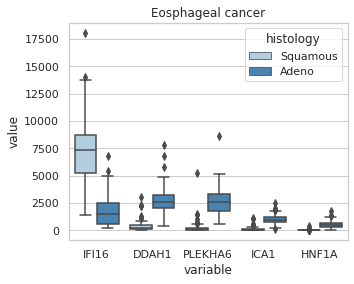

In [36]:
# filter by high adeno genes
sns_source = sns_box_df.loc[sns_box_df['variable'].isin(df2['Gene'][:5])]

# change figure size
sns.set(rc={'figure.figsize':(5,4)})
sns.set_style('whitegrid')
sns_box = sns.boxplot(x='variable', y='value', hue='histology', data=sns_source, palette="Blues")
sns_box.set_title('Eosphageal cancer')


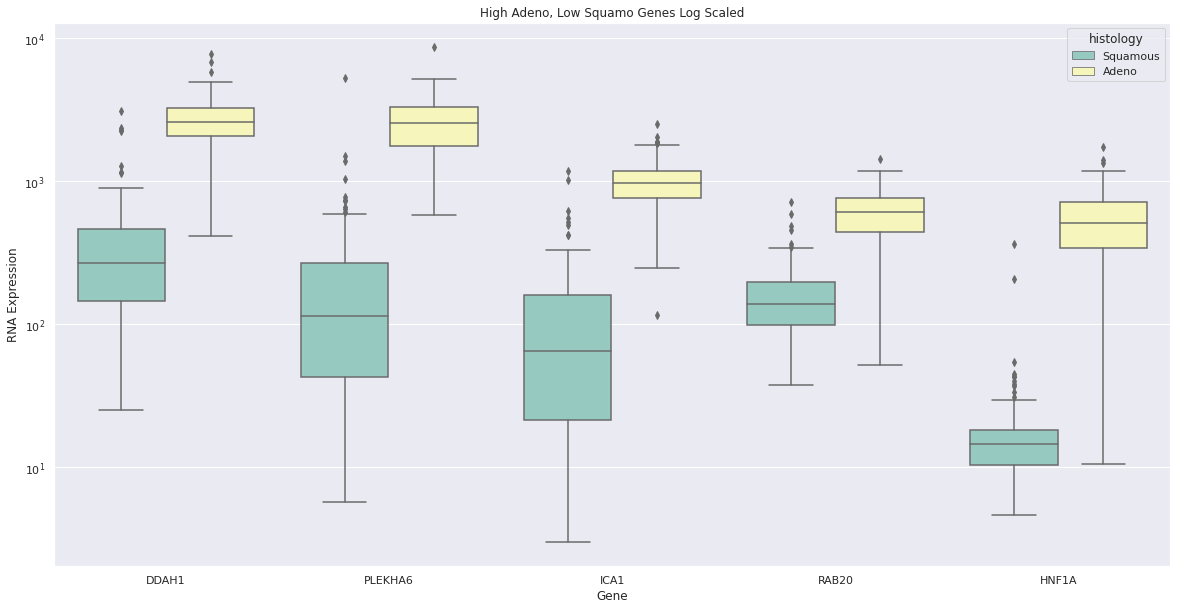

In [37]:
# change figure size
sns_source = sns_box_df.loc[sns_box_df['variable'].isin(df['Gene'][:5])]
sns.set(rc={'figure.figsize':(20,10)})

log_box = sns.boxplot(x='variable', y='value', hue='histology', data=sns_source, palette="Set3")
log_box.set_title('High Adeno, Low Squamo Genes Log Scaled')
# use log scale
log_box.set_yscale('log')
# change axis labels
log_box = log_box.set(xlabel="Gene", ylabel="RNA Expression")

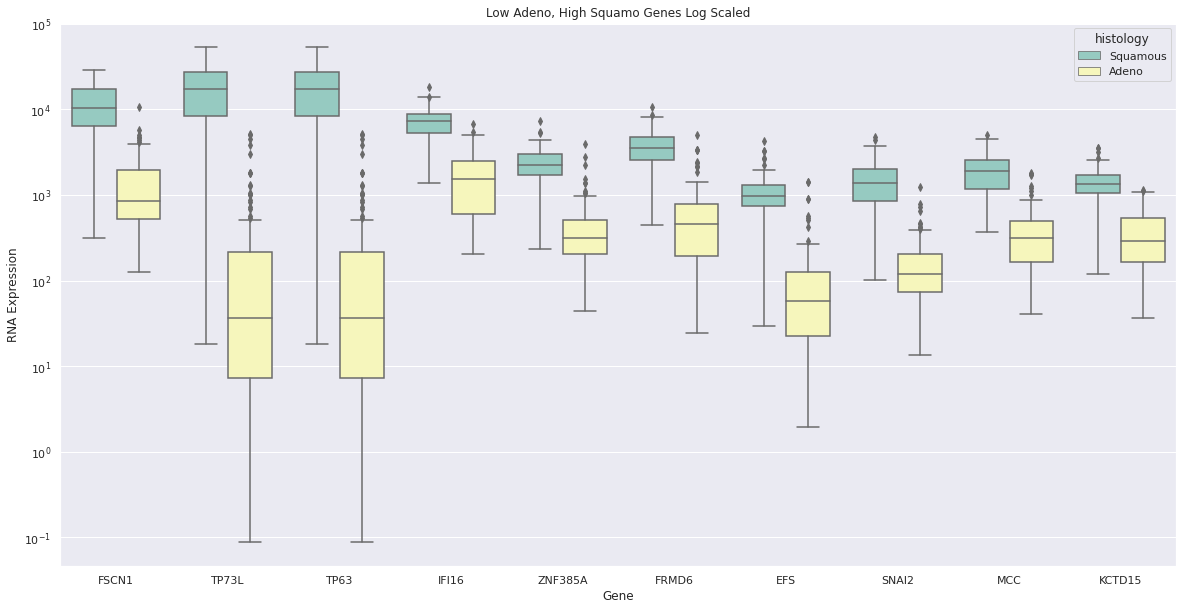

In [38]:
# filter for low adeno, high squamo
sns_source_low = sns_box_df.loc[sns_box_df['variable'].isin(df['Gene'][-10:])]

# change figure size
sns.set(rc={'figure.figsize':(20,10)})

log_box = sns.boxplot(x='variable', y='value', hue='histology', data=sns_source_low, palette="Set3")
log_box.set_title('Low Adeno, High Squamo Genes Log Scaled')
# use log scale
log_box.set_yscale('log')
# change axis labels
log_box = log_box.set(xlabel="Gene", ylabel="RNA Expression")

In [39]:
print('High in adeno, low in squamous:')
print(df['Gene'][:10])
print('Low in adeno, high in squamous')
print(df['Gene'][-10:])

High in adeno, low in squamous:
0       ICA1
0      DDAH1
0    PLEKHA6
0      HNF1A
0      RAB20
0     PRR15L
0       CLMN
0      GPR35
0    SLC44A3
0       GCC2
Name: Gene, dtype: object
Low in adeno, high in squamous
0        EFS
0      FSCN1
0      SNAI2
0        MCC
0      FRMD6
0      TP73L
0       TP63
0    ZNF385A
0     KCTD15
0      IFI16
Name: Gene, dtype: object


### Violin plots

Text(0.5, 1.0, 'High Adeno, Low Squamo Genes')

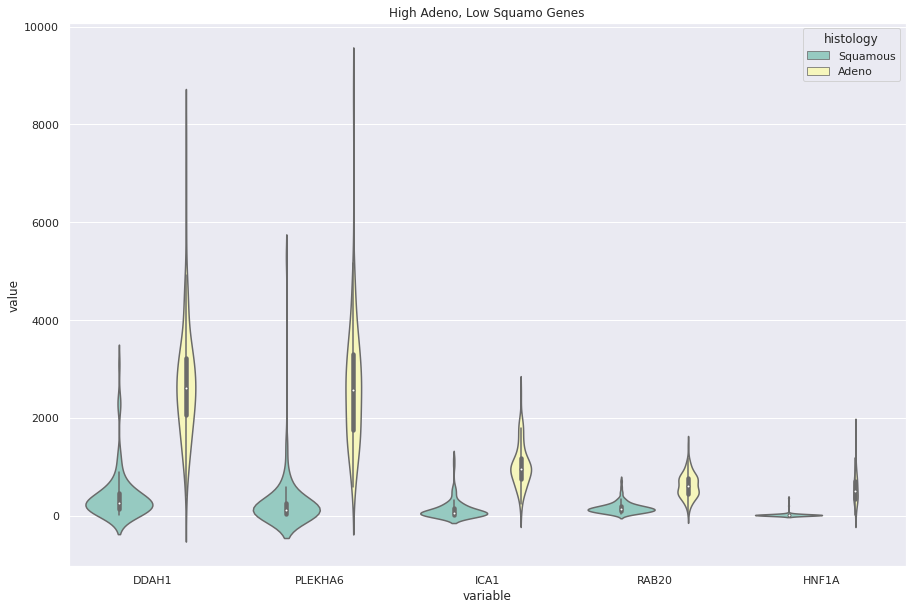

In [40]:
# change figure size
sns.set(rc={'figure.figsize':(15,10)})
sns_violin = sns.violinplot(x='variable', y='value', hue='histology', data=sns_source, palette="Set3")
sns_violin.set_title('High Adeno, Low Squamo Genes')

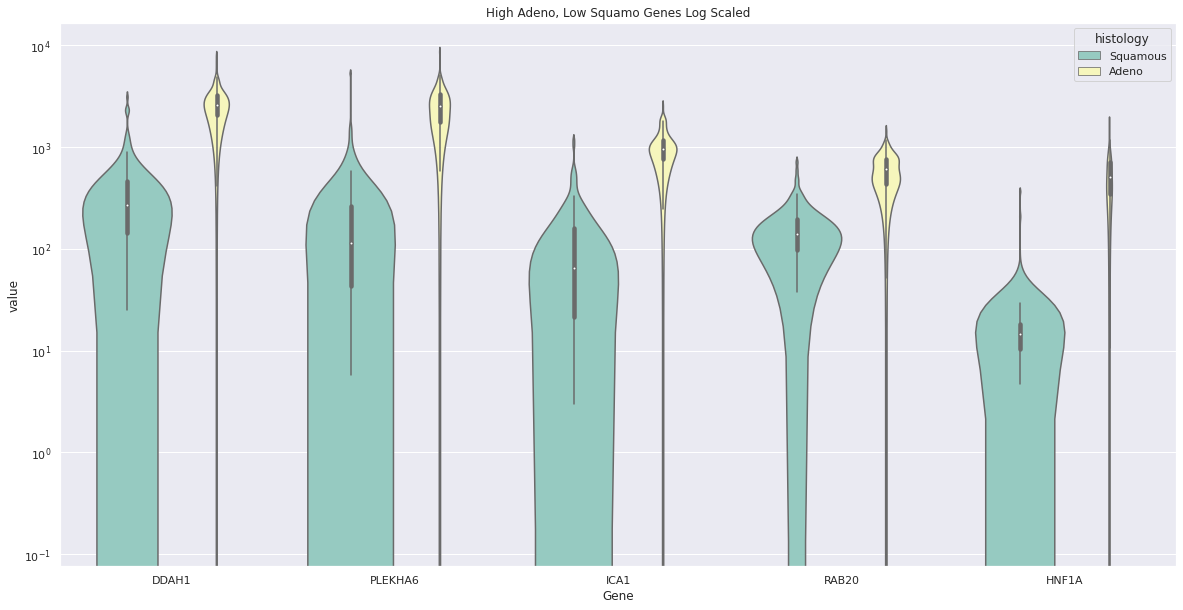

In [41]:
# change figure size
sns.set(rc={'figure.figsize':(20,10)})

log_violin = sns.violinplot(x='variable', y='value', hue='histology', data=sns_source, palette="Set3")
log_violin.set_title('High Adeno, Low Squamo Genes Log Scaled')
# use log scale
log_violin.set_yscale('log')
# change axis labels
log_violin = log_violin.set(xlabel="Gene", ylabel="value")